# Downloading data from USGS

The USGS National Water Information System (NWIS) contains an incredible repository of hydrology and water quality data. These data include both time series, typically collected at 15 minutes intervals, and individual observations and water quality samples. You can learn more about NWIS here.

To help users efficiently access these data, USGS has created R and Python packages containing functions for downloading and organizing data. We are going to use the R version of this package today. It will be helpful for you to review the [Introduction to the dataRetrieval package](https://cran.r-project.org/web/packages/dataRetrieval/vignettes/dataRetrieval.html).

For this module we will focus on collecting the following types of data:
* Site data.
* Hydrology time series data (including stream/river stage and discharge and groundwater level).
* Rating curve data collected by USGS teams for converting stream stage to discharge.
* Surface water chemistry/quality data.

We will begin with **hydrology time series data**.

## Getting R packages loaded


In [2]:
library(dataRetrieval)
library(stringr)
library(gridExtra)
library(ggplot2)
library(reshape2)
library(tidyverse)

#this option controls the number of columns and number of rows that will be displayed when a dataframe or matrix is printed in the Jupyter cell output.
options(repr.matrix.max.cols=40, repr.matrix.max.rows=10)

#this will change the resolution (and therefore display size) of plots. Larger numbers indicate higher resolution, which will produce larger figures.
options(repr.plot.res = 250)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Site Data
Using the _dataRetrieval_ package you can download site data for one or multiple USGS sites. These sites are identified by USGS site identifiers, 8-digit numbers that are unique to each site from which USGS has ever collected data. [USGS has a national map](https://maps.waterdata.usgs.gov/mapper/index.html) of all active and inactive sites from which you can get additional information about each site. When using _dataRetrieval_, sites are identified using these site IDs. If you include multiple sites, site data will be combined into a single dataframe with one row for each site. This dataset contains a lot of useful information, some noteable items area:
* station_nm: station/site name
* lat_va & long_va: latitude and longitude respectively
* huc_cd: the Hydrological Unit Code (HUC) is the watershed address for the stream/river of interest. For more information on how HUCs are generated and used can be [found here](https://en.wikipedia.org/wiki/Hydrological_code).
* contrib_drain_area_va: this is the drainage area (watershed area) for a given stream/river gage.
* well_depth_va: if the site is a groundwater well, the depth of the well will be included here.

In [ ]:
siteNumbers <- c("01491000", "01645000")
siteINFO <- readNWISsite(siteNumbers)

names(siteINFO)
siteINFO

### Identifying data available for sites.
In addition to site identifier codes, USGS NWIS uses two other codes that are key for access data within the system: Parameter codes (_pCode_) and a statistic code (_statCd_).

The _pCode_ is used to select individual parameters/varaibles, including water stage, discharge, temperature, pH, conductance, total dissolved nitrogen, and many additional parameters. Note that all codes are six digits. The table below identifies some common parameter codes and you can also access the [full list of parameter codes](https://help.waterdata.usgs.gov/codes-and-parameters/parameters). There are many parameters that are or have been collected by USGS and its partner agencies. Thus, the parameters are sorted into different categories (e.g., physical, nutrient, and other parameter groups). Below we present a few common parameters codes or reference.


|Parameter Category|pCode|Name|
|-|-|-|
|Physical |00060	|Discharge (ft^3 s^1)|
|Physical |00065	|Gage height (ft)|
|Physical |00010	|Temperature (C)|
|Inorganics, Major, Non-Metals| 00300| Dissolved oxygen, water, unfiltered, (mg L^-1)|
|Physical |00400	|pH|
|Nutrient| 00602	|Nitrate, water, filtered, (mg-N L^-1)|



The Statiscs Code (_statCd_) is a five-digit code used to indicate the statistical aggregation used for primarily continuous data, but can also be useful for individually collected observations. There are many statistics codes that can be used including common statistical metrics listed in the table below. You can also find a (full listing of statics codes)[https://help.waterdata.usgs.gov/stat_code] on the USGS website.


|StatCode|Name|
|-|-|
|00001|	Maximum|
|00002|	Minimum|
|00003|	Mean|
|00008|	Median|




Finally, the NWIS system also allows the user to identify a _service_. This will tell the system whether you want to download an entire dataset or a summarized dataset. Not including this metric when downloading data will result in the full dataset being downloaded. If you need a reduced dataset, you can include options such as daily values (_dv_) or unit values (_uv_). Water quality (_qw_) and groundwater (_gw_) data can also be selected using the _service_ option. For more information about each of these services, you can visit [USGS Water Services](https://waterservices.usgs.gov/)
page.

|Service Code|Service Name|
|-|-|
|dv|daily values|
|uv|unit values|
|qw|water quality|
|sv|site visits|
|pk|peak measurements|
|gw|groundwater levels|
|ad|USGS annual data report sites|

Now that we've gotten that background out of the way, it's time to start looking at some data. First we are going to start with metadata.

## Site information
Now that we know what the possible parameters and data formats available, we want to look at some individual sites to see what is avaialable. _dataRetrieval_ has a function for this called _whatNWISdata_. This function can be used to determine the data variables available for a given site filtered by site number (_siteNumber_), service (_service_), and statistics code (_statCd_). Below is an example for a USGS Super Gage site, the Wabash River at New Harmony, Indiana (USGS ID 03378500). These gage sites are augmented with a wide variety of sensors and routine water quality sampling is conducted at these sites. That means we'll find lots of interesting data to download.

Here we are querying our site looking for daily values (_service = "dv"_) for which mean values are available (_statCd="00003"_) at the daily time step. Here we see that 12 different variables are available with daily mean values. You see which variables these are using the _parm_cd_ column and the [USGS parameter code website](https://help.waterdata.usgs.gov/codes-and-parameters/parameters).

Run the code in the cell block below. What column indicates what variable is represented? How many different variables have been collected at the Wabash River at New Harmony, IN?

In [ ]:
dailyDataAvailable <- whatNWISdata(
  siteNumber = "03378500",
  service = "dv",
  statCd = "00003"
)

dailyDataAvailable

USGS is changing how data are downloaded. Currently the _qw_ service is slated to be deactivated in the coming months. There are other methods of obtaining water quality data from NWIS, but they require functions that are formatted slightly differently. Below is the code that indicates what water quality grab samples have been collected at the Wabash River site. First start by looking at the names of the many columns of data that are returned from this search. Which column contains the parameter code that will tell us what water quality data have been produced. Because there are so many columns in this dataset, we will use the _names_ function first to see all the column names.

In [ ]:
siteWaterQuality <- whatWQPsamples(siteid = "USGS-03378500")
names(siteWaterQuality)

There are a lot of columns. We'll save you some time by pointing to the _ActivityIdentifier_ column. This column has a lot of information. What we want is the last five digits, which are the parameter code we have used previously.

In [ ]:
siteWaterQuality$ActivityIdentifier

So how do we deal with this issue? We can use something called [regular expressions](https://cran.r-project.org/web/packages/stringr/vignettes/regular-expressions.html) to select portions of alphanumeric [strings](https://en.wikipedia.org/wiki/String_(computer_science)) (recall that strings are a data type that is designed for flexible sequences of characters). Using a regular expression, we can select the last five numeric characters where the parameter code is stored. We will then save that in a separate column called pCode following the convention for this abbreviation that is used by _dataRetrieval_. To select five characters one can use the following regular expression \\\\\d{5}\\$ . This will select the last 5 digits ($ indicates the end of the string. R has built in functions that work with regular expressions, but using the package _stringR_, makes writing and using these expressions easier.

We'll start by looking at the results and then we add the parameter codes to the column _pCode_. Note that when saving the parameter codes as a character, this helps preserve the leading zeros in these codes, which would be removed if these codes were converted to a numeric data type.

In [ ]:
str_extract(siteWaterQuality$ActivityIdentifier, '\\d{5}$')
siteWaterQuality$pCode<-as.character(str_extract(siteWaterQuality$ActivityIdentifier, '\\d{5}$'))

## Hydrology Time Series Data Download
Here we will start by downloading stream/river gage data and will progress to groundwater level data second. First up...

### Stream Stage and Discharge
Collection of hydrology data is one of the many core functions of USGS. Thus, working in the US, there is a large amount of data that can be downloaded. We'll start by working with the Wabash River site we used above (Site ID 03378500). Let's download stream discharge (pCode: 00060) and stage (pCode: 00065). We'll start by downloading two months of data.

We will start by downloading instantaneous values and then we will look at daily values.

In [ ]:
wabash_q_iv <- readNWISdata(sites="03378500", service="iv", 
                   parameterCd=c("00065","00060"), 
                   startDate="2014-05-01T00:00",endDate="2014-06-01T12:00",
                   tz="CST")

wabash_q_iv

Next we are going to look at daily values. This is particularly useful if you need to work with large amounts of data. All we have to do is change the service from _dv_ to _iv_ as below. The timestamps are imported in the POSIX format, but in the case of daily data, this can create issues. For that reasons we are changing the dateTime format from POSIX to the R _date_ format. This will simply plotting and remove warning messages. Note that we are adding this to a new column.

In [ ]:
wabash_q_dv <- readNWISdata(sites="03378500", service="dv", 
                   parameterCd=c("00065","00060"), 
                   startDate="2014-05-01",endDate="2014-06-01",
                   tz="CST6CDT")
wabash_q_dv$date<-as.Date(wabash_q_dv$dateTime,tz="CST6CDT")



Now we can plot all the data we've dowloaded. We'll plot the instantaneous discharge and stage and below that include the daily values. We'll make each of the plots and then arrange them with the function _grid.arrange_ from the package _gridExtra_. First, take a look at the structure. Note that the _dataRetrieval_ package has downloaded the data with the _dateTime_ column already formatted in a standardized format (POSIX specification) that can immediately be interpreted by ggplot as a date/time format. Note that we can wrap our axis label functions with the _expression_ function to add formatting such as subscripts and superscripts to these labels.

Note that these plots look very similar at this scale, with the lines for the daily value plots appearing slightly less smooth.

In [ ]:
wabash_q_iv_plot<-ggplot(wabash_q_iv,aes(x=dateTime,y=X_00065_00000))+
geom_line(size=1.3)+
xlab("")+
ylab(expression("Discharge ("*ft^3*"-"*s^-1*")"))

wabash_stage_iv_plot<-ggplot(wabash_q_iv,aes(x=dateTime,y=X_00060_00000))+
geom_line(size=1.3)+
xlab("")+
ylab("Stage (ft)")

wabash_q_dv_plot<-ggplot(wabash_q_dv,aes(x=date,y=X_00065_00003))+
geom_line(size=1.3)+
xlab("")+
ylab(expression("Discharge ("*ft^3*"-"*s^-1*")"))

wabash_stage_dv_plot<-ggplot(wabash_q_dv,aes(x=date,y=X_00060_00003))+
geom_line(size=1.3)+
xlab("")+
ylab("Stage (ft)")

grid.arrange(wabash_q_iv_plot,wabash_stage_iv_plot,wabash_q_dv_plot,wabash_stage_dv_plot,ncol=2)

## Field Hydrology Measurements
Most USGS sensors can only measure the level, also known as stage, of river water. USGS takes field hydrology measurements that can be used to create a relationship between river stage and river water discharge. We're going to start by downloading the field hydrology measurements and then we'll create a plot and set of equations to describe the relationship between stage and discharge at our site.

To do this, when we call _readNWISdata_ we change the _service_ to _measurements_, which indicates that we're going to view USGS field measurements.

In [ ]:
wabash_q_rating <- readNWISdata(sites="03378500", service="measurements",tz="CST6CDT")


wabash_q_rating

Remember that this is the United States federal government so discharge measurements are in ft<sup>3</sup> s</sup>-1</sup> and stage measurements are in ft.

Here we want to use gage height (_gage_height_va_), which reports river stage, and river discharge (_discharge_va_). You can get more information about the field measurement codes at [this page of the USGS website](https://help.waterdata.usgs.gov/codes-and-parameters).

Notice that we do not have a straight line, but instead the slope of the relationship increases at higher water levels. That is because after a river overtops its banks and enters the floodplain, there is much more space for the river to spread out. With this greater cross-sectional area, an increase in stage of one foot now results in a greater increase in water flux (discharge) than before the river went over its banks.

In [ ]:
ggplot(wabash_q_rating,aes(x=gage_height_va,y=discharge_va))+
    geom_point()+
    xlab("Stage (ft)")+
    ylab(expression("Discharge ("*ft^3*"-"*s^-1*")"))

We are going to try four different approaches for fitting a numerical to these data:
* log-transformed linear regression
* quadratic
* third-order polynomial
* LOESS (locally weighted scatterplot smoothing)

We will then get estimates of goodness of fit for each approach and will select the best equation based on this criterion.

In [ ]:
#removing missing values
wabash_q_rating<-subset(wabash_q_rating,!is.na(gage_height_va) & !is.na(discharge_va))

#log-transformed linear regression
wabash_q_rating$log_transform_predict<-10^predict(lm(log10(discharge_va)~gage_height_va,data=wabash_q_rating),newdata=wabash_q_rating)

#quadratic
wabash_q_rating$quadratic_predict<-predict(lm(discharge_va~poly(gage_height_va,2),data=wabash_q_rating),newdata=wabash_q_rating)

#third-order polynomial
wabash_q_rating$poly_3_predict<-predict(lm(discharge_va~poly(gage_height_va,3),data=wabash_q_rating),newdata=wabash_q_rating)

#LOESS
wabash_q_rating$loess_predict <- predict(loess(discharge_va~gage_height_va,data=wabash_q_rating),newdata=wabash_q_rating)


Now we are going to plot the data with root mean square error (RMSE), which is an indication of error. Lower numbers mean a better fitting model.

In [ ]:
log_transform_rmse<-sqrt(mean((wabash_q_rating$discharge_va-wabash_q_rating$log_transform_predict)^2))
quadratic_rmse<-sqrt(mean((wabash_q_rating$discharge_va-wabash_q_rating$quadratic_predict)^2))
poly_3_rmse<-sqrt(mean((wabash_q_rating$discharge_va-wabash_q_rating$poly_3_predict)^2))
loess_rmse<-sqrt(mean((wabash_q_rating$discharge_va-wabash_q_rating$loess_predict)^2))

In [ ]:
ggplot(wabash_q_rating,aes(x=gage_height_va,y=discharge_va))+
    geom_point()+
    xlab("Stage (ft)")+
    ylab(expression("Discharge ("*ft^3*"-"*s^-1*")"))+
    ggtitle("Log-Transformed Linear Regression RMSE:",log_transform_rmse)+
    geom_line(data = wabash_q_rating, aes(x = gage_height_va, y = log_transform_predict), color = "red")

ggplot(wabash_q_rating,aes(x=gage_height_va,y=discharge_va))+
    geom_point()+
    xlab("Stage (ft)")+
    ylab(expression("Discharge ("*ft^3*"-"*s^-1*")"))+
    ggtitle("Quadratic Regression RMSE:",quadratic_rmse)+
    geom_line(data = wabash_q_rating, aes(x = gage_height_va, y = quadratic_predict), color = "red")

ggplot(wabash_q_rating,aes(x=gage_height_va,y=discharge_va))+
    geom_point()+
    xlab("Stage (ft)")+
    ylab(expression("Discharge ("*ft^3*"-"*s^-1*")"))+
    ggtitle("Third Order Polynomial Regression RMSE:",poly_3_rmse)+
    geom_line(data = wabash_q_rating, aes(x = gage_height_va, y = poly_3_predict), color = "red")

ggplot(wabash_q_rating,aes(x=gage_height_va,y=discharge_va))+
    geom_point()+
    xlab("Stage (ft)")+
    ylab(expression("Discharge ("*ft^3*"-"*s^-1*")"))+
    ggtitle("LOESS RMSE:",loess_rmse)+
    geom_line(data = wabash_q_rating, aes(x = gage_height_va, y = loess_predict), color = "red")

## Water Quality Sensor Data
Water quality sensor data can also be obtained from many sites, but many more sites do not have these sensors deployed. Thus, it can be difficult for users to track down appropriate sources of data. Fortunately, the _dataRetrieval_ package has functions that will allow us to do this.

First we're going to use a function called _whatNWISdata_ to find out where we can find different types of data. First we're going to look for all USGS sites located in Indiana with _in situ_ nitrate sensors.

In [ ]:
siteListNitrate <- whatNWISsites(stateCd = "IN", parameterCd = "99133")
siteListNitrate

We've found 20 sites with _in situ_ nitrate sensors. This does not mean that all these sensors are active at a given time. Sensors can be deployed for long term periods or, in some cases, only a few years of data are available before the sensor is removed.

Note from the list that we've produced above, that there are groundwater sites included in this list: _site_tp_cd_ is _GW_. We will look at the unique sites types that are available and then restrict our list to stream or river sites using the subset command. Here we see that there are stream (ST), lake (LK) and groundwater (GW) sites.

In [ ]:
#listing the unique site type codes
unique(siteListNitrate$site_tp_cd)

#subsetting to only stream sites
siteListNitrate_st<-subset(siteListNitrate,site_tp_cd=="ST")

Now that we have a list of sites of interest, we want to find out what is available for each of these sites. For this we can use the function _readNWISdata_. You can either choose one or multiple sites. Here we're choosing two sites Wabash River at New Harmony (03378500) and White River at Hazelton (03374100). For both sites we are going to request discharge (00060), temperature (00010), and nitrate sensor (99133) data. We are specifying _iv_ for service, which will return instantaneous, not summarized, data. Switching _iv_ to _dv_ will instead return daily mean values for each variable at each site.

To ensure that all the desired data are downloaded, start timestamps (_startDate_) should be used. The end timestamp (_endDate_) can also be specified, but if you leave this unspecified, the query will operate properly and you will get data from the _startDate_ up to present.

In [ ]:
IN_No3 <- readNWISdata(sites=c("03378500","03374100"), service="iv", 
                   parameterCd=c("00060","00010","99133"),
                   startDate="2022-01-01T00:00Z",endDate="2022-12-31T23:59Z")

We've dowloaded a year of data and now we'd like to plot these data together for each site. To do this will have to do a little bit of data manipulation. We'll use the _melt_ function in the R package _reshape2_ to convert our wide-formatted data to long-formatted data that will be easier to plot. Note that we are only selecting columns containing data and are removing quality control columns (e.g., those ending with __cd_). Also note that there are sensors positioned at multiple locations at the Wabash River site. We are only selecting the main sensors that are directly monitoring the river channel itself.

In [ ]:
IN_No3_tomelt<-IN_No3[,c("site_no","dateTime","X_00010_00000","X_00060_00000","X_99133_00000")]

IN_No3_toplot<-melt(IN_No3_tomelt,id=c("site_no","dateTime"))

#We can convert our categorical values to factors and then add labels that will be plotted
IN_No3_toplot$site_no<-factor(IN_No3_toplot$site_no, levels = c("03374100","03378500"), labels = c("White River", "Wabash River"))
IN_No3_toplot$variable<-factor(IN_No3_toplot$variable, levels = c("X_00060_00000","X_00010_00000","X_99133_00000"), labels = c("Discharge (CFS)", "Temperature (C)","Nitrate + Nitrate (mg-N/L)"))


In [ ]:
IN_No3_plot<-ggplot(IN_No3_toplot,aes(dateTime,value))+
    geom_line()+
    facet_wrap(~variable+site_no, scales="free_y", ncol=2)

IN_No3_plot

## Groundwater Well Data
The last time of time series data we'll look at is groundwater well data. These data are obtained in a fashion fairly similar to the other time series data we've accessed so far. The first thing we want to do is identify some groundwater sites to look at. Below we will download a dataframe that contains all the sites with groundwater data in Indiana using the _whatNWISsites_ function. There are two ways we can do this. First, we can use the approach above, downloading a list of all sites in Indiana and subsetting _site_tp_cd_ to only include _GW_ sites. The other alternative is to find all sites with groundwater data available. In this case, we actually have to use three parameter codes to capture all the ways that groundwater data are reported by USGS in Indiana. Usually each site only reports one type of data, depending on when the site was commissioned or upgraded. The three parameter codes we will use for downloading groundwawter level data are:

|pCode|Description|
|-|-|
|30210|Depth to water level, below land surface datum (LSD)|
|30211|Elevation above NGVD 1929, meters|
|62611|Groundwater level above NAVD 1988, feet|

First we'll download all the sites in Indiana and narrow down.

In [ ]:
siteListGroundwater <- whatNWISsites(stateCd = "IN")
siteListGroundwater
siteListGroundwater <- subset(siteListGroundwater, site_tp_cd=="GW")
siteListGroundwater

This gives us a lot of rows! Let's use the parameter codes to narrow down the data to the sites that we need. The list is still pretty long, but it will help you narrow down to sites that are more likely to have active groundwater well monitoring. We'll also specifically look at the parameter code 30210 (Depth to water level, below land surface datum) and then select one of those sites to download and plot available data.

In [ ]:
siteListGroundwaterIndiana <- whatNWISsites(stateCd = "IN", parameterCd = c("30210","30211","62611"))
siteListGroundwaterIndiana

siteListGroundwaterIndiana_30210 <- whatNWISsites(stateCd = "IN", parameterCd = c("30210"))
siteListGroundwaterIndiana_30210




The _dataRetrieval_ package has an alternate function for downloading groundwater level data (_readNWISgwl_). Here we will download data from Morgan County in Indiana.

In [ ]:
GroundwaterMorgan <- readNWISgwl("393423086161001")
GroundwaterMorgan

Note that the groundwater level data are stored in a column called _lev_va_. We will plot these values to see how water level has changed since 1983. We can look at the depth from surface of groundwater (_lev_va_) or the level of groundwater above sea level (_sl_lev_va_). We will plot the latter.

In [ ]:
ggplot(GroundwaterMorgan,aes(lev_dt,sl_lev_va))+
geom_point() +
xlab("")+
ylab("Groundwater Level above Sea Level (ft)")

## Water Quality Data

Now we are going to download some water quality "grab" samples. The USGS will be shutting down their water quality service (_qw_). The new service is operational, but 
the _dataRetrieval_ package has not been updated to accomplish all tasks required so we will use the older functions for now, keeping in mind that this workflow will change slightly. When this happens, the _dataRetrival_ documentation linked to above will be updated.

Here we are going to find all the sites in Indiana that have filtered total dissolved nitrogen (00602) or othorphosphate (00660) data available.

In [ ]:
nitrogen_orthophosphate_sites <- whatNWISdata(
  parameterCd = c("00602","00660"),
  stateCd = "IN",
  service = "qw"
)

nitrogen_orthophosphate_sites


Choosing from the sites above, we'll start by downloading ortho-phosphate data from the Whitewater River near Economy, IN (Site ID 03274650). We don't end up getting much data, but you can use _count_nu_ variable in the dataframe _nitrogen_orthophosphate_sites_ to find sites with a greater number of samples available!

In [ ]:
WhitewaterRiver_orthop <- readNWISqw(siteNumbers=c("03274650"),
                     parameterCd=c("00602")
                        )
WhitewaterRiver_orthop

# Now it's your turn!
## Plotting discharge

First we're going to select a site and generate a plot of discharge over the last year. Replace the Wabash River ID with a site you've selected from the [USGS National Map](https://maps.waterdata.usgs.gov/mapper/index.html).

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


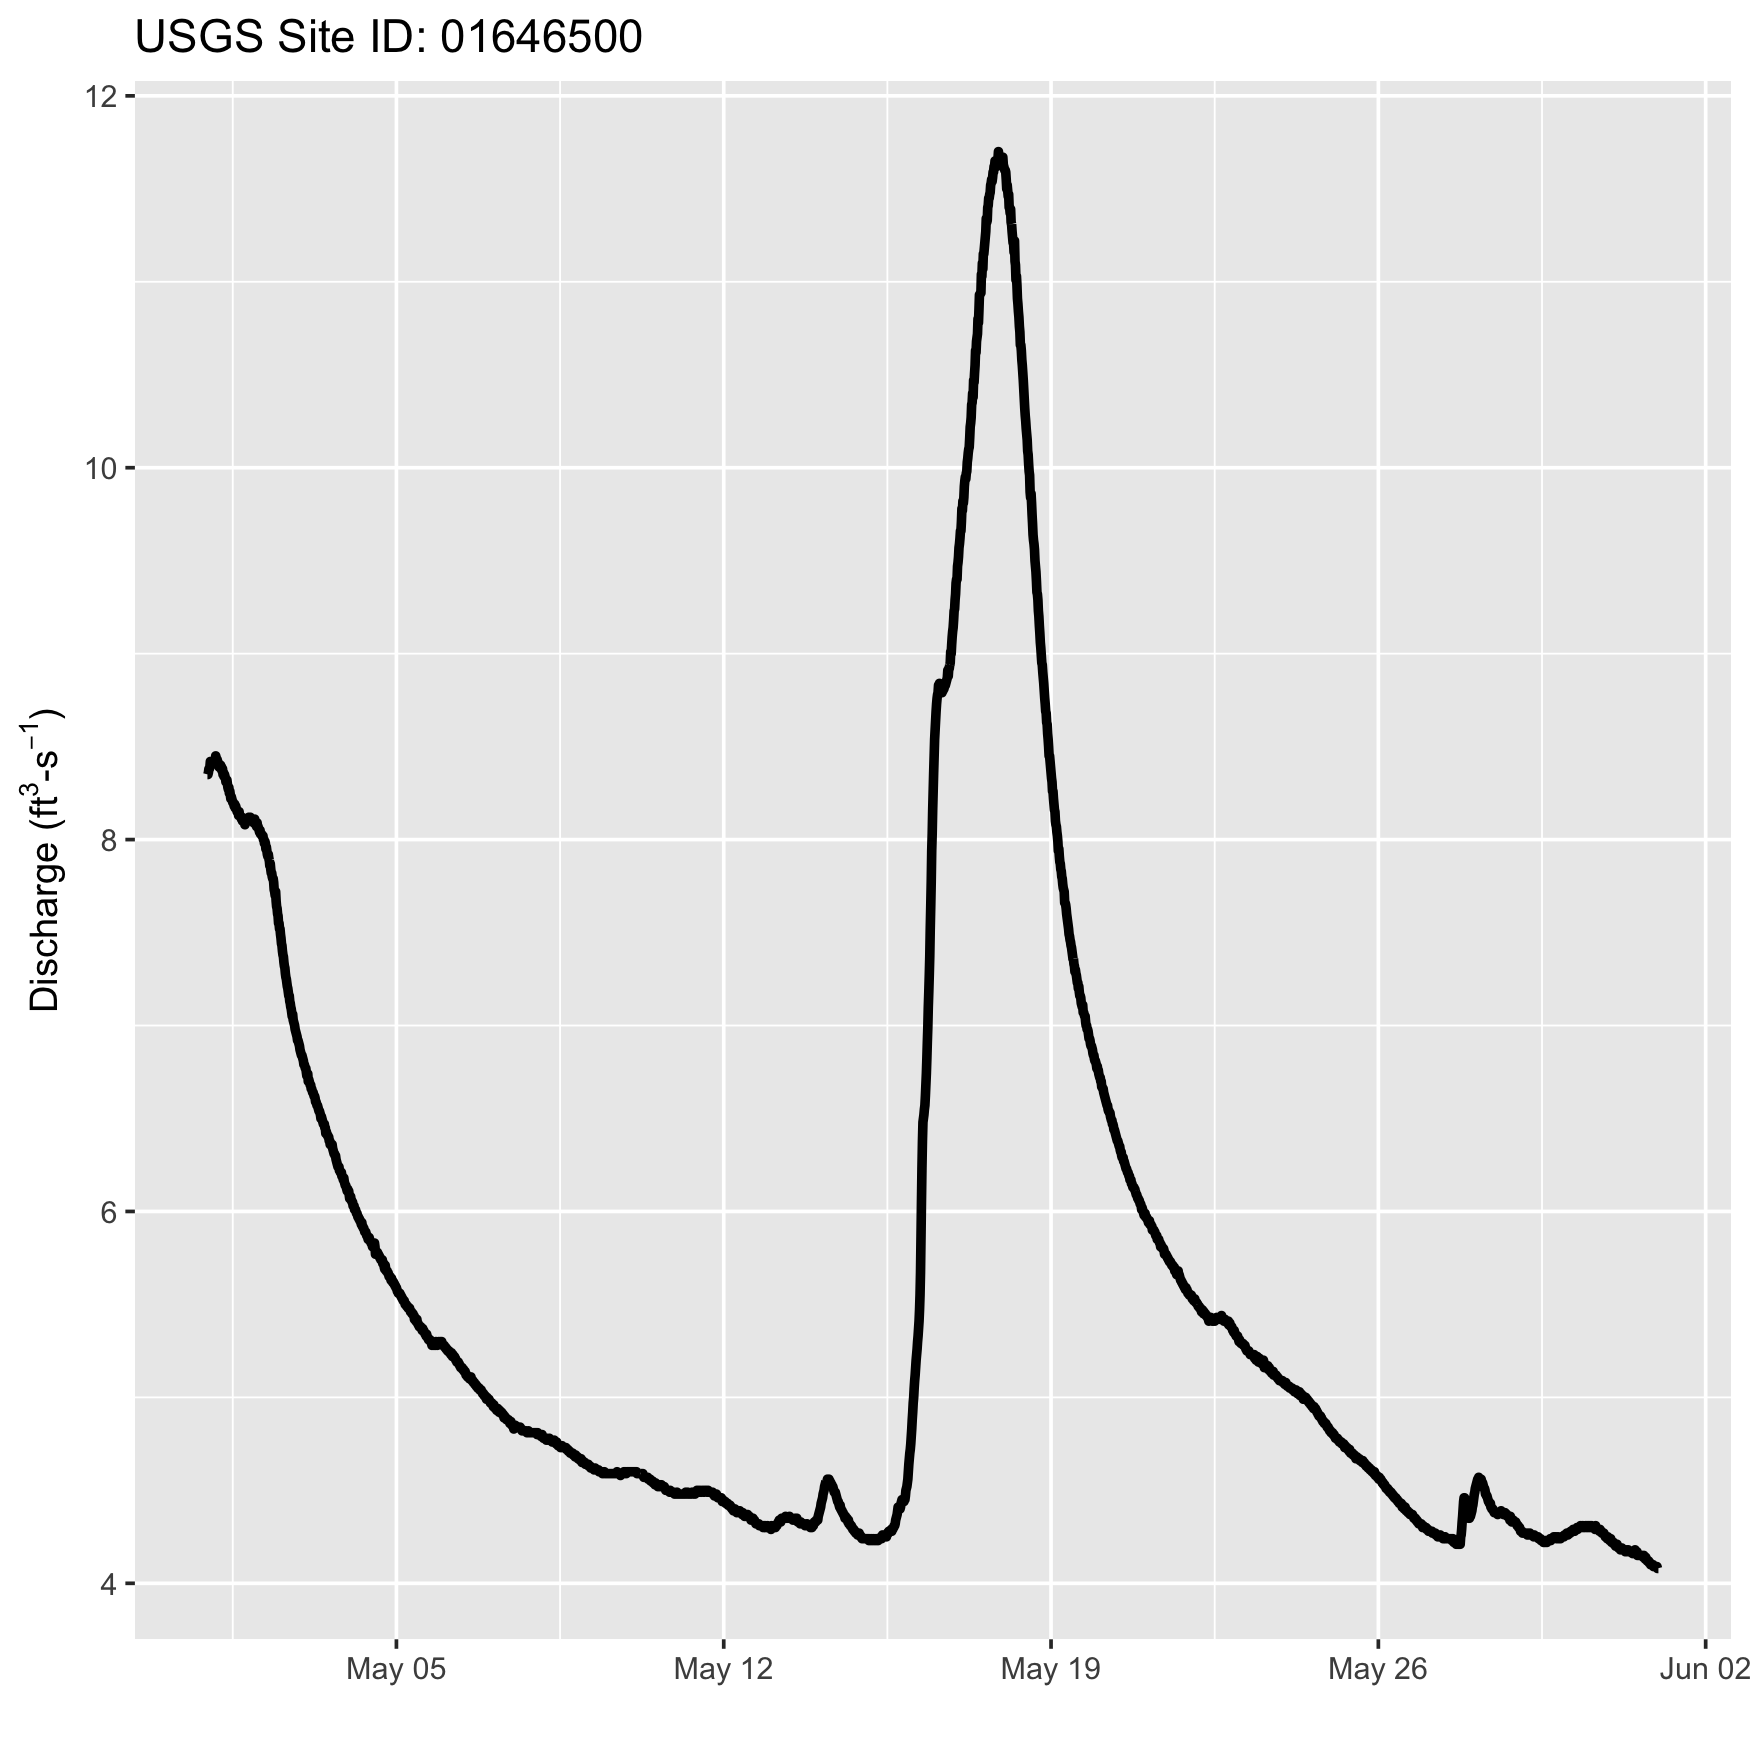

In [3]:
usgs_site<-"01646500"

site_q_iv <- readNWISdata(sites=usgs_site, service="iv", 
                   parameterCd=c("00065","00060"), 
                   startDate="2014-05-01T00:00",endDate="2014-06-01T12:00",
                   tz="CST")

site_q_iv_plot<-ggplot(site_q_iv,aes(x=dateTime,y=X_00065_00000))+
geom_line(size=1.3)+
xlab("")+
ylab(expression("Discharge ("*ft^3*"-"*s^-1*")"))+
ggtitle(paste("USGS Site ID:",usgs_site))

site_q_iv_plot

## Rating Curves
Now we're going to plot rating curves for our site and select the best equation

In [5]:
site_q_rating <- readNWISdata(sites=usgs_site, service="measurements",tz="CST6CDT")


site_q_rating

agency_cd,site_no,measurement_nu,measurement_dt,q_meas_used_fg,party_nm,site_visit_coll_agency_cd,gage_height_va,discharge_va,measured_rating_diff,gage_va_change,gage_va_time,control_type_cd,discharge_cd,tz_cd
<chr>,<chr>,<dbl>,<dttm>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
USGS,01646500,1,1930-03-25 16:40:00,Yes,M/S/B,USGS,3.25,8740,Unspecified,0.00,1.1,NA,NONE,CST6CDT
USGS,01646500,2,1930-03-29 08:45:00,Yes,M/M,USGS,3.17,8540,Unspecified,-0.03,2.9,NA,NONE,CST6CDT
USGS,01646500,3,1930-04-09 09:15:00,Yes,M/S,USGS,4.25,15000,Unspecified,NA,NA,NA,NONE,CST6CDT
USGS,01646500,4,1930-06-05 14:45:00,Yes,M/S,USGS,1.42,1940,Unspecified,0.00,1.8,NA,NONE,CST6CDT
USGS,01646500,5,1930-07-14 12:15:00,Yes,S/B,USGS,1.06,1200,Unspecified,0.00,2.2,NA,NONE,CST6CDT
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
USGS,01646500,401,2023-08-29 10:52:27,Yes,NCG/LCT,USGS,2.46,617,Poor,0.00,1.10,DebrisLight,NONE,CST6CDT
USGS,01646500,402,2023-10-24 10:37:27,Yes,RWP/NCG,USGS,2.66,1330,Poor,0.00,0.45,DebrisLight,NONE,CST6CDT
USGS,01646500,403,2024-01-30 10:26:48,Yes,JTABLTSQ,USGS,8.04,68900,Fair,0.00,0.28,NA,NONE,CST6CDT


In [6]:
#removing missing values
site_q_rating<-subset(site_q_rating,!is.na(gage_height_va) & !is.na(discharge_va))

#log-transformed linear regression
site_q_rating$log_transform_predict<-10^predict(lm(log10(discharge_va)~gage_height_va,data=site_q_rating),newdata=site_q_rating)
lm(log10(discharge_va)~gage_height_va,data=site_q_rating)



Call:
lm(formula = log10(discharge_va) ~ gage_height_va, data = site_q_rating)

Coefficients:
   (Intercept)  gage_height_va  
        3.0967          0.1592  


In [7]:
#quadratic
site_q_rating$quadratic_predict<-predict(lm(discharge_va~poly(gage_height_va,2),data=site_q_rating),newdata=site_q_rating)
lm(discharge_va~poly(gage_height_va,2),data=site_q_rating)



Call:
lm(formula = discharge_va ~ poly(gage_height_va, 2), data = site_q_rating)

Coefficients:
             (Intercept)  poly(gage_height_va, 2)1  poly(gage_height_va, 2)2  
                   23834                   1026851                    269131  


In [8]:
#third-order polynomial
site_q_rating$poly_3_predict<-predict(lm(discharge_va~poly(gage_height_va,3),data=site_q_rating),newdata=site_q_rating)
lm(discharge_va~poly(gage_height_va,3),data=site_q_rating)


Call:
lm(formula = discharge_va ~ poly(gage_height_va, 3), data = site_q_rating)

Coefficients:
             (Intercept)  poly(gage_height_va, 3)1  poly(gage_height_va, 3)2  
                   23834                   1026851                    269131  
poly(gage_height_va, 3)3  
                 -110507  


In [9]:
#LOESS
site_q_rating$loess_predict <- predict(loess(discharge_va~gage_height_va,data=site_q_rating),newdata=site_q_rating)
loess(discharge_va~gage_height_va,data=site_q_rating)

Call:
loess(formula = discharge_va ~ gage_height_va, data = site_q_rating)

Number of Observations: 403 
Equivalent Number of Parameters: 5.67 
Residual Standard Error: 11560 

In [10]:
log_transform_rmse<-sqrt(mean((site_q_rating$discharge_va-site_q_rating$log_transform_predict)^2))
quadratic_rmse<-sqrt(mean((site_q_rating$discharge_va-site_q_rating$quadratic_predict)^2))
poly_3_rmse<-sqrt(mean((site_q_rating$discharge_va-site_q_rating$poly_3_predict)^2))
loess_rmse<-sqrt(mean((site_q_rating$discharge_va-site_q_rating$loess_predict)^2))

In [ ]:
ggplot(site_q_rating,aes(x=gage_height_va,y=discharge_va))+
    geom_point()+
    xlab("Stage (ft)")+
    ylab(expression("Discharge ("*ft^3*"-"*s^-1*")"))+
    ggtitle("Log-Transformed Linear Regression RMSE:",log_transform_rmse)+
    geom_line(data = site_q_rating, aes(x = gage_height_va, y = log_transform_predict), color = "red")

ggplot(site_q_rating,aes(x=gage_height_va,y=discharge_va))+
    geom_point()+
    xlab("Stage (ft)")+
    ylab(expression("Discharge ("*ft^3*"-"*s^-1*")"))+
    ggtitle("Quadratic Regression RMSE:",quadratic_rmse)+
    geom_line(data = site_q_rating, aes(x = gage_height_va, y = quadratic_predict), color = "red")

ggplot(site_q_rating,aes(x=gage_height_va,y=discharge_va))+
    geom_point()+
    xlab("Stage (ft)")+
    ylab(expression("Discharge ("*ft^3*"-"*s^-1*")"))+
    ggtitle("Third Order Polynomial Regression RMSE:",poly_3_rmse)+
    geom_line(data = site_q_rating, aes(x = gage_height_va, y = poly_3_predict), color = "red")

ggplot(site_q_rating,aes(x=gage_height_va,y=discharge_va))+
    geom_point()+
    xlab("Stage (ft)")+
    ylab(expression("Discharge ("*ft^3*"-"*s^-1*")"))+
    ggtitle("LOESS RMSE:",loess_rmse)+
    geom_line(data = site_q_rating, aes(x = gage_height_va, y = loess_predict), color = "red")